# Delta Parameter Models: SVA, SS, and Global Tilt

This notebook develops machine learning models to predict postoperative changes in key sagittal alignment parameters, specifically Sagittal Vertical Axis, Sacral Slope, and Global Tilt. 


In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score

from xgboost import XGBRegressor

from src import config

## Data and Preprocessing

The models in this notebook use the cleaned dataset produced by the shared data cleaning pipeline. 


In [2]:
# Load cleaned data from config path
df = pd.read_csv(config.DATA_PROCESSED)
df.columns = df.columns.astype(str).str.replace("\n"," ").str.replace(r"\s+"," ", regex=True).str.strip()

print(f"Loaded {df.shape[0]} patients, {df.shape[1]} columns")
print(f"Data path: {config.DATA_PROCESSED}")

Loaded 277 patients, 99 columns
Data path: /Users/vanjaglisic/Documents/UW_MSDS/CAPSTONE/repo work/Data-Science-Capstone/data/processed/cleaned_for_modeling.csv


## Modeling Approach

For each alignment parameter, a regression model is trained to predict the postoperative change (postoperative value minus preoperative value). Features include patient demographics, preoperative alignment measurements, and surgical plan variables. An XGBoost regressor is used in combination with a preprocessing pipeline that handles missing values and categorical variables.


In [3]:
# Angular change targets
df["delta_SVA"] = df["SVA_postop"] - df["SVA_preop"]
df["delta_SS"] = df["SS_postop"] - df["SS_preop"]

# Global tilt: note postop column name
df["delta_GlobalTilt"] = df["global_tilt.1"] - df["global_tilt"]


In [4]:
# Patient preop numeric features
PATIENT_NUMERIC = [
    "age",
    "bmi",
    "PI_preop",
    "PT_preop",
    "LL_preop",
    "SS_preop",
    "T4PA_preop",
    "L1PA_preop",
    "SVA_preop",
    "cobb_main_curve_preop",
    "FC_preop",
    "tscore_femneck_preop",
    "HU_UIV_preop",
    "HU_UIVplus1_preop",
    "HU_UIVplus2_preop",
    "L4S1_preop"
]

# Surgical plan / recipe
PLAN_NUMERIC = [
    "num_rods",
    "num_pelvic_screws",
    "osteotomy"
]

PLAN_BINARY = [
    "ALIF",
    "XLIF",
    "TLIF"
]

PLAN_CATEGORICAL = [
    "UIV_implant",
    "num_levels"   # upper / lower
]

PATIENT_CATEGORICAL = [
    "sex"
]

NUMERIC_FEATURES = PATIENT_NUMERIC + PLAN_NUMERIC
CATEGORICAL_FEATURES = PATIENT_CATEGORICAL + PLAN_CATEGORICAL

FEATURES = NUMERIC_FEATURES + PLAN_BINARY + CATEGORICAL_FEATURES


In [5]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, NUMERIC_FEATURES + PLAN_BINARY),
        ("cat", categorical_transformer, CATEGORICAL_FEATURES)
    ]
)


In [6]:
def train_delta_model(df, target_col, model_name):
    data = df[FEATURES + [target_col]].dropna(subset=[target_col])

    X = data[FEATURES]
    y = data[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = XGBRegressor(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_test)

    print(f"\n{model_name}")
    print("MAE:", round(mean_absolute_error(y_test, preds), 3))
    print("R² :", round(r2_score(y_test, preds), 3))

    return pipe, X_test, y_test, preds


## Model Evaluation

Model performance is evaluated using mean absolute error (MAE) and R². These metrics provide a measure of prediction accuracy and the proportion of variance explained by the model. In addition to numerical metrics, diagnostic plots are used to assess prediction behavior and error patterns.


In [7]:
sva_model = train_delta_model(df, "delta_SVA", "ΔSVA Model")
ss_model  = train_delta_model(df, "delta_SS", "ΔSS Model")
gt_model  = train_delta_model(df, "delta_GlobalTilt", "ΔGlobal Tilt Model")



ΔSVA Model
MAE: 29.984
R² : 0.522

ΔSS Model
MAE: 7.293
R² : 0.309

ΔGlobal Tilt Model
MAE: 7.589
R² : 0.382


In [8]:
sva_model, X_test_sva, y_test_sva, y_pred_sva = train_delta_model(
    df, "delta_SVA", "ΔSVA Model"
)



ΔSVA Model
MAE: 29.984
R² : 0.522


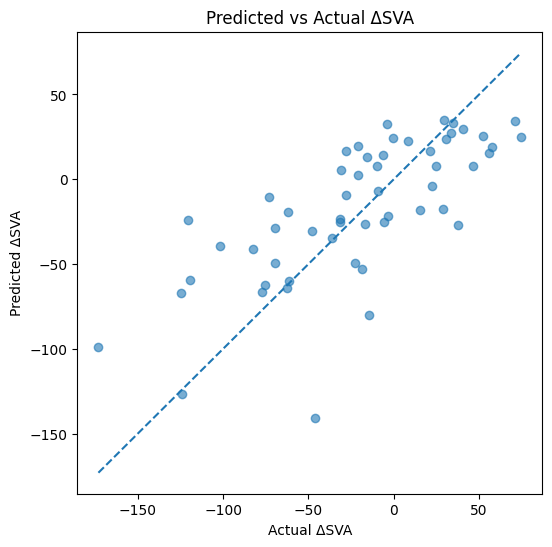

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test_sva, y_pred_sva, alpha=0.6)
plt.plot(
    [y_test_sva.min(), y_test_sva.max()],
    [y_test_sva.min(), y_test_sva.max()],
    linestyle="--"
)
plt.xlabel("Actual ΔSVA")
plt.ylabel("Predicted ΔSVA")
plt.title("Predicted vs Actual ΔSVA")
plt.show()


### Predicted vs Actual SVA

The predicted versus actual plot shows that model predictions generally follow the overall trend of observed postoperative changes. While variability increases for larger corrections, the model captures both the direction and magnitude of alignment changes across a wide range of cases.


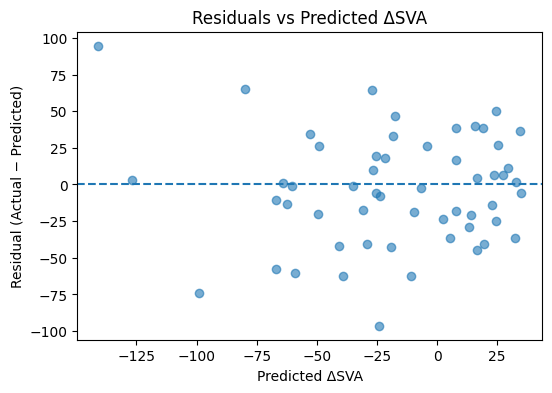

In [10]:
residuals = y_test_sva - y_pred_sva

plt.figure(figsize=(6,4))
plt.scatter(y_pred_sva, residuals, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted ΔSVA")
plt.ylabel("Residual (Actual − Predicted)")
plt.title("Residuals vs Predicted ΔSVA")
plt.show()


### Residual Analysis

Residuals are centered around zero without strong systematic patterns, indicating limited bias in the model predictions. The spread of residuals increases for more extreme corrections, which likely reflects underlying clinical heterogeneity rather than model instability.


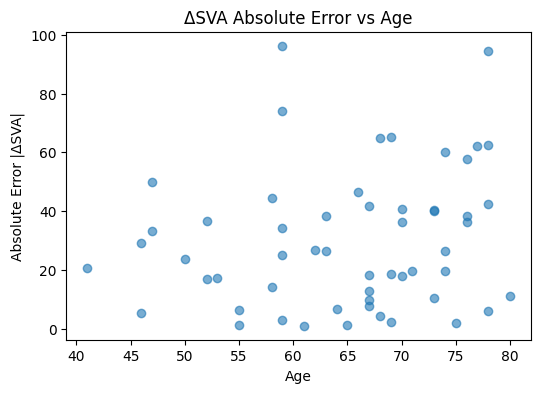

In [11]:
# Absolute error vs age
age_test = X_test_sva["age"]
abs_error = abs(y_test_sva - y_pred_sva)

plt.figure(figsize=(6,4))
plt.scatter(age_test, abs_error, alpha=0.6)
plt.xlabel("Age")
plt.ylabel("Absolute Error |ΔSVA|")
plt.title("ΔSVA Absolute Error vs Age")
plt.show()


## Save Models

Save trained models as joblib bundles containing the pipeline and feature list.

In [12]:
import joblib

# Train all models fresh and save
sva_pipe, _, _, _ = train_delta_model(df, "delta_SVA", "ΔSVA Model")
ss_pipe, _, _, _ = train_delta_model(df, "delta_SS", "ΔSS Model")
gt_pipe, _, _, _ = train_delta_model(df, "delta_GlobalTilt", "ΔGlobal Tilt Model")

# Save SVA model
sva_dir = config.ARTIFACTS_DIR / "SVA"
sva_dir.mkdir(parents=True, exist_ok=True)
bundle_sva = {
    "pipe": sva_pipe,
    "features": FEATURES,
    "target": "delta_SVA",
    "model_name": "XGBRegressor_delta_SVA"
}
out_path = sva_dir / "delta_SVA_model.joblib"
joblib.dump(bundle_sva, out_path)
print(f"Saved: {out_path}")

# Save SS model
ss_dir = config.ARTIFACTS_DIR / "SS"
ss_dir.mkdir(parents=True, exist_ok=True)
bundle_ss = {
    "pipe": ss_pipe,
    "features": FEATURES,
    "target": "delta_SS",
    "model_name": "XGBRegressor_delta_SS"
}
out_path = ss_dir / "delta_SS_model.joblib"
joblib.dump(bundle_ss, out_path)
print(f"Saved: {out_path}")

# Save Global Tilt model
gt_dir = config.ARTIFACTS_DIR / "GlobalTilt"
gt_dir.mkdir(parents=True, exist_ok=True)
bundle_gt = {
    "pipe": gt_pipe,
    "features": FEATURES,
    "target": "delta_GlobalTilt",
    "model_name": "XGBRegressor_delta_GlobalTilt"
}
out_path = gt_dir / "delta_GlobalTilt_model.joblib"
joblib.dump(bundle_gt, out_path)
print(f"Saved: {out_path}")


ΔSVA Model
MAE: 29.984
R² : 0.522

ΔSS Model
MAE: 7.293
R² : 0.309

ΔGlobal Tilt Model
MAE: 7.589
R² : 0.382
Saved: /Users/vanjaglisic/Documents/UW_MSDS/CAPSTONE/repo work/Data-Science-Capstone/artifacts/SVA/delta_SVA_model.joblib
Saved: /Users/vanjaglisic/Documents/UW_MSDS/CAPSTONE/repo work/Data-Science-Capstone/artifacts/SS/delta_SS_model.joblib
Saved: /Users/vanjaglisic/Documents/UW_MSDS/CAPSTONE/repo work/Data-Science-Capstone/artifacts/GlobalTilt/delta_GlobalTilt_model.joblib
